<a href="https://colab.research.google.com/github/pachterlab/LHKP_2023/blob/main/gget_elm_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and import packages:

In [1]:
!pip install -q mysql-connector-python==8.0.29
!pip install -q git+https://github.com/pachterlab/gget.git@dev
!pip install -q biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 33.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.0 MB/s eta 0:00:00


In [2]:
# !pip install -q gget biopython
import gget
import requests
import time
from io import StringIO
import pandas as pd
import numpy as np
from Bio import SeqIO
from google.colab import files
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from tqdm import tqdm
TQDM_BAR_FORMAT = (
    "{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]"
)

In [3]:
gget.setup("elm")

   % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 % To  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0tal    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2123k  100 2123k    0     0   182k      0  0:00:11  0:00:11 --:--:--  515k
100 87336  100 87336    0     0   4160      0  0:00:20  0:00:20 --:--:-- 19119
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  914k  100  914k    0     0   8479      0  0:01:50  0:01:50 --:--:--  225k


### Download amino acid sequences and accessions from UniProt for speed testing:

In [4]:
!wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz
!gunzip uniprot_sprot.fasta.gz

--2024-01-10 18:15:00--  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91975468 (88M) [application/x-gzip]
Saving to: ‘uniprot_sprot.fasta.gz’

uniprot_sprot.fasta 100%[===================>]  87.71M   144MB/s    in 0.6s    

2024-01-10 18:15:01 (144 MB/s) - ‘uniprot_sprot.fasta.gz’ saved [91975468/91975468]



### Find ELMs using the ELM server API and `gget elm`
Note: The ELM API officially only allows 1 request per min for amino acid sequenes, and 1 request per 3 min for UniProt IDs. Here, we are setting the sleep time between requests to 3 min regardless of input data type to minimize '429 too many requests' errors. This sleep time is not taken into account in the speed comparison plot below, although it restricts scalable use of the ELM server for large queries.

In [5]:
elm_api = "http://elm.eu.org/start_search/"

In [6]:
def compare_results(api_response, regex):
    ## Clean up results returned by the ELM API
    api_df = pd.read_csv(StringIO(api_response), sep='\t')

    # Rename columns to match data frame returned by gget elm
    api_df.rename(columns={'elm_identifier': 'ELMIdentifier'}, inplace=True)
    api_df.rename(columns={'start': 'motif_start_in_query'}, inplace=True)
    api_df.rename(columns={'stop': 'motif_end_in_query'}, inplace=True)

    # Only keep columns relevant to the result comparison
    api_df_clean = api_df[['ELMIdentifier', 'motif_start_in_query', 'motif_end_in_query']]

    ## Clean up results returned by gget elm
    # Only keep columns relevant to the result comparison and drop duplicates which resulted from dropping the additional information
    regex_clean = regex[["ELMIdentifier", "motif_start_in_query", "motif_end_in_query"]].drop_duplicates().reset_index(drop=True)

    # Compare data frames
    df_comp = regex_clean.merge(api_df_clean, on=['ELMIdentifier', 'motif_start_in_query', 'motif_end_in_query'], how='outer', indicator=True)
    # Return fraction of results that were not contained in both data frames
    return len(df_comp[df_comp["_merge"] == 'both']) / len(df_comp)

In [8]:
# Define the number of sequences and IDs to analyze
num_seqs = 50

api_time_aa = []
api_time_id = []
gget_time_aa = []
gget_time_id = []
aa_overlap = []
id_overlap = []
with tqdm(total=num_seqs, bar_format=TQDM_BAR_FORMAT) as pbar:
  for i, record in enumerate(SeqIO.parse("uniprot_sprot.fasta", "fasta")):
    ## Find motifs from the amino acid sequence using the ELM API
    # Sleep for at least 3 min between ELM server requests
    time.sleep(180)

    # Record start time
    start_time = time.time()
    # Submit request to ELM API
    r_aa = requests.get(elm_api + str(record.seq))
    # Record time passed since start
    total_time = time.time() - start_time

    if r_aa.status_code == 200:
      api_time_aa.append(total_time)
    else:
      api_time_aa.append(np.nan)

    ## Find motifs from the UniProt Acc using the ELM API
    # Sleep for at least 3 min between ELM server requests
    time.sleep(180)

    # Record start time
    start_time = time.time()
    # Submit request to ELM API
    r_id = requests.get(elm_api + record.id.split("|")[1] + ".tsv")
    # Record time passed since start
    total_time = time.time() - start_time

    if r_id.status_code == 200:
      api_time_id.append(total_time)
    else:
      api_time_id.append(np.nan)


    ## Find motifs from the amino acid sequence using gget.elm
    # Record start time
    start_time = time.time()
    # Submit sequence to gget elm
    _, regex_aa = gget.elm(str(record.seq))
    # Record time passed since start
    gget_time_aa.append(time.time() - start_time)

    ## Find motifs from the UniProt Acc using gget.elm
    # Record start time
    start_time = time.time()
    # Submit UniProt Acc to gget elm
    _, regex_id = gget.elm(record.id.split("|")[1], uniprot=True)
    # Record time passed since start
    gget_time_id.append(time.time() - start_time)


    ## Record fraction of returned results that overlap between the API and gget elm
    if r_aa.status_code == 200:
      aa_overlap.append(compare_results(r_aa.text, regex_aa))
    else:
      aa_overlap.append(np.nan)

    if r_id.status_code == 200:
      id_overlap.append(compare_results(r_id.text, regex_id))
    else:
      id_overlap.append(np.nan)


    pbar.update(n=1)
    if i == num_seqs-1:
        break

100%|██████████| 50/50 [elapsed: 5:29:30 remaining: 00:00]


### Plot runtimes and result overlap

In [9]:
# Concatenate runtimes and results into a data frame
df = pd.DataFrame()

df["api_time_id"] = api_time_id
df["api_time_aa"] = api_time_aa
df["gget_time_aa"] = gget_time_aa
df["gget_time_id"] = gget_time_id
df["aa_overlap"] = aa_overlap
df["id_overlap"] = id_overlap

# Save and download runtime data frame
df.to_csv("runtimes.csv", index=False)
files.download('runtimes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
df

,api_time_id,api_time_aa,gget_time_aa,gget_time_id,aa_overlap,id_overlap
0,9.715618,20.321839,2.742618,2.867672,1.0,1.0
1,11.356644,20.772133,2.385612,3.006542,1.0,1.0
2,14.276111,21.441167,3.358116,4.023164,1.0,1.0
3,8.633096,16.393669,1.812083,2.503839,1.0,1.0
4,14.461482,23.530792,3.701478,3.523329,1.0,1.0
5,7.539692,14.919181,1.558652,2.130954,1.0,1.0
6,14.423743,17.608152,2.505281,2.634549,1.0,1.0
7,8.843679,17.617697,2.006427,2.894350,1.0,1.0
8,11.075278,22.696445,2.399470,3.871844,1.0,1.0
9,9.743032,14.688694,1.658609,2.138750,1.0,1.0


In [33]:
def rand_jitter(arr, jitter_size=0.02):
    """
    Add random jitter to array to avoid overplotting scatter plot.
    """
    return np.random.uniform(low=-jitter_size, high=jitter_size, size=(len(arr),))

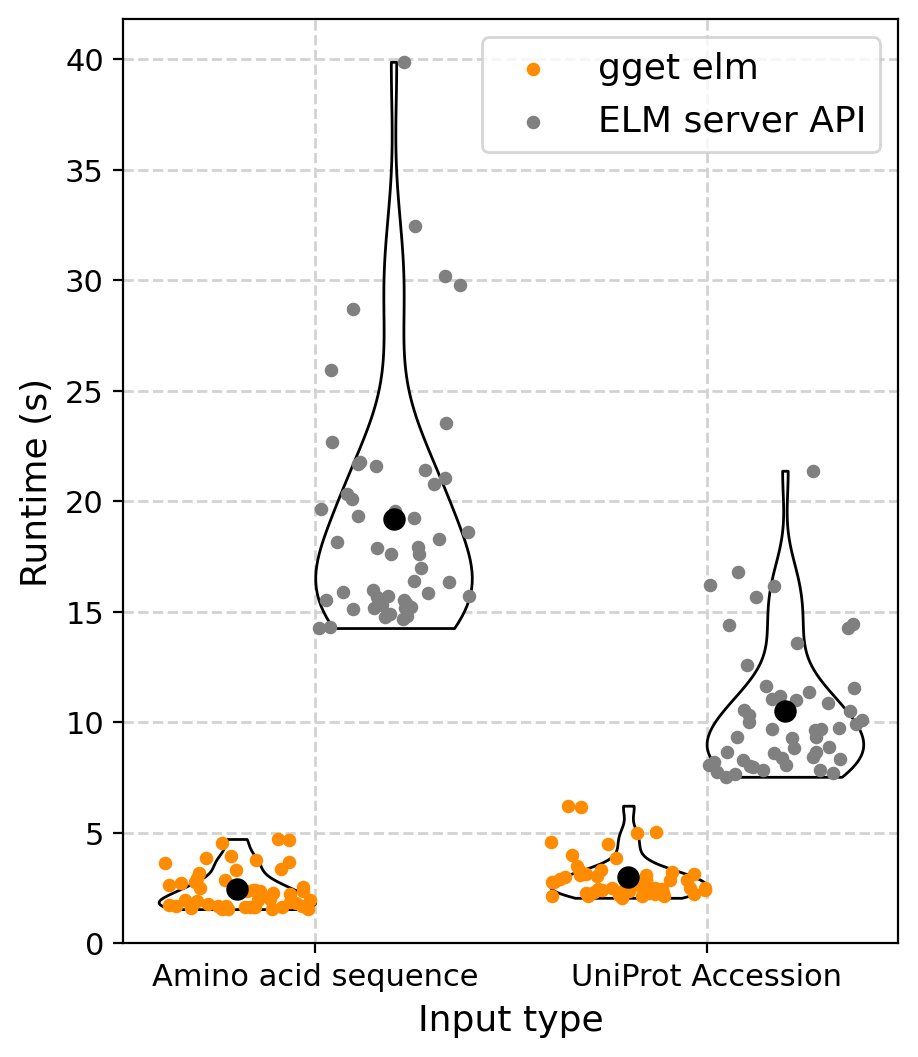

In [65]:
fig, ax = plt.subplots(figsize=(5, 6))
width = 0.4
fontsize = 11

# Plot runtimes
x_labels = ["Amino acid sequence", "UniProt Accession"]

values_to_plot = [
    df["gget_time_aa"].values,
    df["api_time_aa"].dropna().values,
    df["gget_time_id"].values,
    df["api_time_id"].dropna().values
    ]
positions = [-width/2, width/2, 1-width/2, 1+width/2]
colors = ["darkorange", "grey", "darkorange", "grey"]
labels = ["gget elm", "ELM server API", None, None]
for pos, values, color, label in zip(positions, values_to_plot, colors, labels):
  # Plot violin plot
  v = ax.violinplot(values, [pos], widths=width, vert=True, showmedians=False, showextrema=False)
  for pcidx, pc in enumerate(v["bodies"]):
      pc.set_facecolor("white")
      pc.set_edgecolor("black")
      pc.set_alpha(1)
  # Plot all data points
  ax.scatter([pos]*len(values) + rand_jitter([pos]*len(values), width/2), values, s=15, color=color, label=label)
  # Plot the mean
  ax.scatter(pos, np.mean(values), s=50, color="black")

ax.set_xticks([0,1], x_labels)
ax.set_ylim(bottom=0)

ax.set_ylabel("Runtime (s)", fontsize=fontsize+2)
ax.set_xlabel("Input type", fontsize=fontsize+2)

ax.legend(fontsize=fontsize+2)

ax.tick_params(axis="both", labelsize=fontsize)
ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

fig.savefig("gget_elm_benchmark.png", dpi=300, bbox_inches="tight")

fig.show()

In [56]:
print(f"gget elm average runtime to generate amino acid results: {np.round(np.mean(df['gget_time_aa'].values),2)}s")
print(f"gget elm average runtime to generate UniProt Acc results: {np.round(np.mean(df['gget_time_id'].values),2)}s")
print(" ")
print(f"gget elm variance of runtime to generate amino acid results: {np.round(np.var(df['gget_time_aa'].values),2)}s")
print(f"gget elm variance of runtime to generate UniProt Acc results: {np.round(np.var(df['gget_time_id'].values),2)}s")
print(" ")
print(f"ELM server average runtime to generate amino acid results (excl. 3 min sleep time between requests): {np.round(np.mean(df['api_time_aa'].dropna().values),2)}s")
print(f"ELM server average runtime to generate UniProt Acc results (excl. 3 min sleep time between requests): {np.round(np.mean(df['api_time_id'].dropna().values),2)}s")
print(" ")
print(f"ELM server variance of runtime to generate amino acid results (excl. 3 min sleep time between requests): {np.round(np.var(df['api_time_aa'].dropna().values),2)}s")
print(f"ELM server variance of runtime to generate UniProt Acc results (excl. 3 min sleep time between requests): {np.round(np.var(df['api_time_id'].dropna().values),2)}s")

gget elm average runtime to generate amino acid results: 2.45s
gget elm average runtime to generate UniProt Acc results: 3.02s
 
gget elm variance of runtime to generate amino acid results: 0.78s
gget elm variance of runtime to generate UniProt Acc results: 0.93s
 
ELM server average runtime to generate amino acid results (excl. 3 min sleep time between requests): 19.22s
ELM server average runtime to generate UniProt Acc results (excl. 3 min sleep time between requests): 10.53s
 
ELM server variance of runtime to generate amino acid results (excl. 3 min sleep time between requests): 27.64s
ELM server variance of runtime to generate UniProt Acc results (excl. 3 min sleep time between requests): 8.6s


In [15]:
print(f"Number of server errors returned for amino acid sequences from the ELM API: {len(df['api_time_aa'].values) - len(df['api_time_aa'].dropna().values)}")
print(f"Number of server errors returned for UniProt Accessions from the ELM API: {len(df['api_time_id'].values) - len(df['api_time_id'].dropna().values)}")

Number of server errors returned for amino acid sequences from the ELM API: 0
Number of server errors returned for UniProt Accessions from the ELM API: 0


In [14]:
aa_overlap_values = df["aa_overlap"].dropna().values
id_overlap_values = df["id_overlap"].dropna().values
print(f"The average agreement between results returned by gget elm and the ELM API server for amino acid sequences was: {np.mean(aa_overlap_values*100)}%")
print(f"The average agreement between results returned by gget elm and the ELM API server for UniProt Accessions was: {np.mean(id_overlap_values*100)}%")


The average agreement between results returned by gget elm and the ELM API server for amino acid sequences was: 100.0%
The average agreement between results returned by gget elm and the ELM API server for UniProt Accessions was: 100.0%
